# Introduction

In [2]:
from os import environ as env
env['TF_CPP_MIN_LOG_LEVEL'] = '2'               # hide info & warnings
env['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'       # grow GPU memory as needed

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds

import nstesia as nst

tfds.disable_progress_bar()                     # progress bar mangles output

In [10]:
style_images = [
    nst.utils.image.load_images(file, min_dim=256)
    for file in [
        'img/candy.jpeg',
        'img/mondrian.jpeg',
        'img/starry-night.jpeg',
        'img/triangles.jpeg',
    ]
]
n_styles = len(style_images)

In [4]:
coco_ds = tfds.load('coco/2014', split='train', data_dir='/tmp')
coco_ds = coco_ds.map( lambda data: tf.cast(data['image'], dtype=tf.float32) )
coco_ds = coco_ds.map( lambda image: tf.image.resize(image, [256,256]) )

enum_ds = tf.data.Dataset.from_tensor_slices(
    [i for i in range(len(style_images))]
).repeat()

train_ds = tf.data.Dataset.zip((coco_ds,enum_ds))
train_ds = train_ds.batch(4).prefetch(tf.data.AUTOTUNE)

Dataset coco downloaded and prepared to /tmp/coco/2014/1.1.0. Subsequent calls will reuse this data.


In [5]:
class DumoulinTrainer(tf.keras.models.Model):
    """
    Dumoulin Style Transfer Model Trainer.

    Args:
        style_images:
                A list or tuple of 3-D style image tensors.
    """

    def __init__(self, transfer_model, style_images, **kwargs):
        super().__init__(**kwargs)

        self.style_images = style_images
        self.n_styles = len(style_images)
        self.transfer_model = transfer_model

    def call(self, inputs, **kwargs):        
        style_vector = tf.one_hot(inputs[1], self.n_styles)
        stylized_image = self.transfer_model((inputs[0], style_vector))

        return (stylized_image, inputs[1])

    def compile(self, optimizer, total_loss_fn, **kwargs):
        super().compile(optimizer, **kwargs)
        self.total_loss_fn = total_loss_fn

    def train_step(self, data):
        content_image = data[0]
        style_index = data[1]

        with tf.GradientTape() as tape:
            generated_image = self((content_image,style_index), training=True)[0]

            total_loss = self.total_loss_fn(
                (content_image,style_index), (generated_image,style_index)
            )

        gradients = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients,self.trainable_variables))

        return { 'total_loss': total_loss }

In [6]:
class DumoulinStyleLoss(tf.keras.losses.Loss):

    def __init__(self, style_images, model='vgg16', **kwargs):
        super().__init__(**kwargs)

        self.style_images = style_images

        if isinstance(model, str):
            self.style_model = nst.models.GatysStyle(model=model)
        else:
            self.style_model = model

        # tuple of tensors of shape (N,Cl,Cl) where
        # - N is the number of style images, and
        # - Cl is the number of features in layer l
        self.style_targets = tuple(
            tf.concat(features, 0)
            for features in zip(*tuple(
                self.style_model(image) for image in self.style_images
            ))
        )

    def call(self, y_true, y_pred):
        stylized_image = y_pred[0]
        style_no = y_pred[1]

        style_targets = tuple(
            tf.gather(target, style_no) for target in self.style_targets
        )
        style_features = self.style_model(stylized_image)

        style_layer_losses = [
            tf.reduce_mean(tf.square(target-feature))
            for target, feature in zip(style_targets, style_features)
        ]

        return tf.add_n(style_layer_losses) / len(style_layer_losses)

In [7]:
class DumoulinContentLoss(tf.keras.losses.Loss):

    def __init__(self, model='vgg16', **kwargs):
        super().__init__(**kwargs)

        self.gatys_content_loss = nst.losses.GatysContent(model=model)

    def call(self, y_true, y_pred):
        content_image = y_true[0]
        stylized_image = y_pred[0]

        return self.gatys_content_loss(content_image, stylized_image)

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-3)

total_loss_fn = nst.losses.Total(
    losses=[
        DumoulinStyleLoss(style_images),
        DumoulinContentLoss(),
    ],
    weights=(7.0,1.0)
)

transfer_model = nst.models.DumoulinStyleTransfer(len(style_images))
trainer_model = DumoulinTrainer(transfer_model, style_images)

trainer_model.compile(optimizer, total_loss_fn)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        f'weights/dumoulin2017-exp1-{{epoch}}.h5', save_freq='epoch'
    )
]

trainer_model.fit(train_ds, callbacks=callbacks, epochs=5)

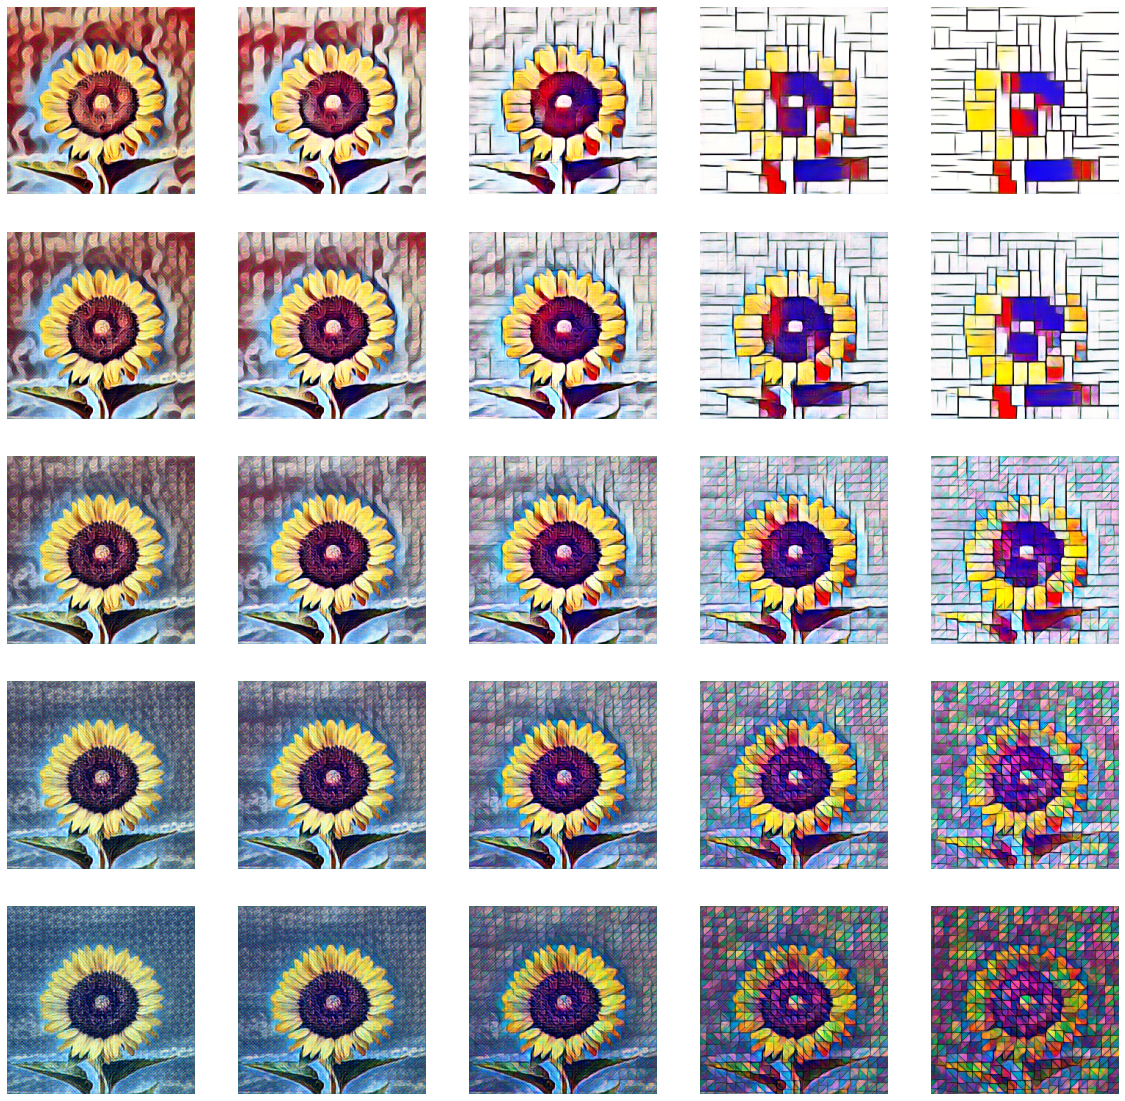

In [16]:
content_image = nst.utils.image.load_images('img/sunflower.jpeg', min_dim=256)

stylized_images = []
for i in range(5):
    for j in range(5):
        style_vector = tf.reshape(
            (4-i)*(4-j) * tf.one_hot(0,n_styles) +
            (4-i) * j   * tf.one_hot(1,n_styles) +
              i * (4-j) * tf.one_hot(2,n_styles) +
              i  *  j   * tf.one_hot(3,n_styles),
            (1,-1)
        ) / 16
        stylized_images.append(
            transfer_model( (content_image, style_vector) )
        )

nst.utils.image.show_images(stylized_images, n_cols=5)

# References
1. Dumoulin, Shlens, Kudlur - _A Learned Representation for Artistic Style_, 2017.
2. Gatys, Ecker, Bethge - _Texture Synthesis Using Convolutional Neural Networks_, 2015.
3. Gatys, Ecker, Bethge - _A Neural Algorithm of Artistic Style_, 2015.
4. Johnson, Alahi, Fei-Fei - _Perceptual Losses for Real-Time Style Transfer and Super-Resolution_, 2016.
5. Ulyanov, Vedaldi, Lempitsky - _Instance Normalization: The Missing Ingredient for Fast Stylization_, 2016.
6. Lin et al - _Microsoft COCO: Common Objects in Context_, 2014.
